## Taller de cuantificación

### Parte 1: Descarga del dataset necesario

In [1]:
import os
import zipfile

zip_url = "https://zenodo.org/records/11661820/files/T1.train_dev.zip?download=1"
zip_path = "T1.train_dev.zip"
extracted_folder = "T1.train_dev"

# Download with system wget (Jupyter syntax)
if not os.path.exists(zip_path):
    print("Downloading dataset...")
    !wget -O $zip_path "$zip_url"
else:
    print("ZIP file already exists.")

# Extract if not already extracted
if not os.path.exists(extracted_folder):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_folder)
    print("Extraction complete.")
else:
    print("Dataset already extracted.")

ZIP file already exists.
Dataset already extracted.


### Parte 2: Instalación de las librerías necesarias

In [17]:
!pip install pandas
!pip install matplotlib
!pip install quantificationlib
!pip install scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### Parte 3. Leyendo el dataset.
Este dataset contiene reviews de productos de amazon. Cada review puede ser positiva o negativa (campo `label`). El texto de cada review ha sido convertido a una representación numérica para su facilidad de uso. Diponemos de 5000 ejemplos de entrenamiento (5000 opiniones).

In [3]:
import pandas as pd

dataset = pd.read_csv('T1.train_dev/T1/public/training_data.txt')

print(dataset)

      label        0       1        2        3         4        5        6  \
0         1  1.10940 -1.5099  0.26001 -0.62786 -0.356860  0.32722 -1.00670   
1         1  0.94284 -1.3486  0.35036 -0.68159 -0.046541  0.45244 -1.25130   
2         1  0.94738 -1.4309  0.22982 -0.84249 -0.414650  0.56810 -1.38980   
3         1  1.02150 -1.4751  0.29282 -0.66289 -0.003578  0.37674 -1.20800   
4         1  1.07030 -1.1924  0.23481 -0.54509 -0.228920  0.27440 -1.00250   
...     ...      ...     ...      ...      ...       ...      ...      ...   
4995      1  0.90753 -1.5766  0.13906 -1.00270 -0.210630  0.51940 -1.02110   
4996      1  1.01900 -1.4851  0.43065 -0.75151 -0.089563  0.43897 -1.10860   
4997      0  1.00370 -1.0824  0.27074 -0.88833 -0.337040  0.63238 -1.10940   
4998      1  0.99343 -1.4536  0.36971 -1.16970  0.099819  0.40902 -0.84970   
4999      1  0.88026 -1.3862  0.42127 -0.87045 -0.328340  0.55201 -0.46403   

           7         8  ...      246       247       248      2

### Analizando la prevalencia de las clases original en el dataset de etrenamiento.
Como podemos ver, un alto porcentaje de las opiniones son positivas.

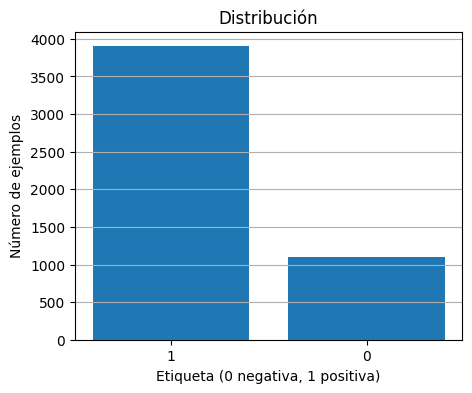

In [5]:
import matplotlib.pyplot as plt

# Count examples per label
label_counts = dataset['label'].value_counts()

# Plot
plt.figure(figsize=(5, 4))
plt.bar(label_counts.index.astype(str), label_counts.values)
plt.xlabel('Etiqueta (0 negativa, 1 positiva)')
plt.ylabel('Número de ejemplos')
plt.title('Distribución')

plt.grid(axis='y')
plt.show()


### Aprendiendo a cuantificar. El método Clasificar y Contar
Vamos a empezar con la solución trivial del problema de la cuantificación: entrenar un clasificador y contar las predicciones de cada ejemplo de la bag de test que queremos cuantificar.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np

X = dataset.drop(columns=["label"]).values
y = dataset["label"].values

#Dividimos nuestro dataset en train y test, separando el 30% de los ejemplos para test y asegurando que la proporción original de etiquetas se mantiene en ambos conjuntos.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train: {len(y_train)} ejemplos (Proporción positivos: {np.mean(y_train):.2f}) | Test: {len(y_test)} ejemplos (Proporción positivos: {np.mean(y_test):.2f})")

Train: 3500 ejemplos (Proporción positivos: 0.78) | Test: 1500 ejemplos (Proporción positivos: 0.78)


Entrenamos un clasificador y clasificamos lo ejemplos de test. Como podemos ver, el error absoluto de este cuantificador (AE) es bajo, predice bastante bien la prevalencia de la clse positiva en la bag de test. Este problema es en realidad trivial ya que en nuestro setup la prevalencia de las clases **no ha cambiado** entre train y test: $P_{train}(y)=P_{test}(y)$

In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
# Predeccimos los ejemplos de test y contamos la proporción de positivos en las predicciones.
cc_prevalence = np.mean(y_pred)
true_prevalence = np.mean(y_test)

print(f"Clasificar y contar (porcentaje postivos): {cc_prevalence:.4f}")
print(f"Porcentaje positivos real: {true_prevalence:.4f}")
print(f"Error absoluto cuantificador: {np.abs(cc_prevalence-true_prevalence):.4f}")

Clasificar y contar (porcentaje postivos): 0.8127
Porcentaje positivos real: 0.7800
Error absoluto cuantificador: 0.0327


### ¿Qué sucede si la distribución $P(y)$ cambia entre train y test $P_{train}(y) \neq P_{test}(y)$?
Para probarlo, generamos una nueva bolsa de test con 500 ejemplos, pero en este caso, la mayoría van a ser negativos (400 de 500).
Como podemos comprobar ahora, si repetimos el procedimiento de antes y utilizamos CC para cuantificar, el error absoluto entre la predicción del cuantificador y la prevalencia real es mucho mayor.

In [ ]:
# Calculamos los índices de los ejemplos negativos y positivos en el conjunto de test
neg_indices = np.where(y_test == 0)[0]
pos_indices = np.where(y_test == 1)[0]

# Elegimos el número de ejemplos negativos y positivos que queremos en nuestra bag
n_neg, n_pos = 400, 100

# Muestreamos aleatoriamente con reemplazmiento los índices de los ejemplos negativos y positivos
sampled_neg = np.random.choice(neg_indices, size=n_neg, replace=True)
sampled_pos = np.random.choice(pos_indices, size=n_pos, replace=True)

# Combinamos y barajamos los índices de la bag
bag_indices = np.concatenate([sampled_neg, sampled_pos])
np.random.shuffle(bag_indices)

# Creamos la bag con los ejemplos seleccionados
X_bag = X_test[bag_indices]
y_bag = y_test[bag_indices]

# Imprimir información sobre la bag
print(f"Número de ejemplos en test: {len(y_bag)} | Proporción positivos: {np.mean(y_bag):.1f}")

# Aplicamos el método clasificar y contar (CC) a la bag
y_pred = clf.predict(X_bag)
cc_prevalence = np.mean(y_pred)
true_prevalence = np.mean(y_bag)

print(f"Clasificar y contar (porcentaje positivos): {cc_prevalence:.4f}")
print(f"Porcentaje positivos real: {true_prevalence:.2f}")
print(f"Error absoluto cuantificador: {np.abs(cc_prevalence-true_prevalence):.4f}")


Número de ejemplos en test: 500 | Proporción positivos: 0.2
Clasificar y contar (porcentaje postivos): 0.4620
Porcentaje positivos real: 0.20
Error absoluto cuantificador: 0.2620


### Automatizando la cuantificación (quantificationlib)

Hasta ahora hemos cuantificado, con un cuantificador trivial (CC) a mano. Para cuantificar disponemos de software específico, como por ejemplo la librería de cuantificación **quantificationlib** (https://aicgijon.github.io/quantificationlib/).

Veamos como utilizar CC usando quantificationlib.

In [11]:
from quantificationlib.baselines.cc import CC
from quantificationlib.metrics.multiclass import mean_absolute_error

# Creamos un objeto CC que corresponde al método clasificar y contar (CC) e indicamos que queremos el mismo clasificador que hemos utilizado antes (clf).
quantifier_cc = CC(estimator_test=clf)
quantifier_cc.fit(X_train,y_train)
# Predeccimos la misma bag con el cuantificador CC (deberíamos de obtener los mismos resultados que antes)
p_pred=quantifier_cc.predict(X_bag)

true_prevalence = np.array([0.8,0.2])

print(f"Clasificar y contar (porcentaje postivos): {p_pred[1]}")
print(f"Prevalencia real: {true_prevalence[1]}")
# También disponemos de funciones para calcular errores de cuantificación como el error absoluto
print(f"Error absoluto cuantificador: {mean_absolute_error(p_pred,true_prevalence)}")

Clasificar y contar (porcentaje postivos): 0.462
Prevalencia real: 0.2
Error absoluto cuantificador: 0.262


### Utilizando cuantificadores más avanzados
En este caso vamos a utilizar un cuantificador especialmente diseñador para lidiar con situaciones de prior probability shift. Este método es un cuantificador básico conocido como Adjusted Count (AC).

Como podemos ver este cuantificador mejora muchísimo el resultado de CC.

In [12]:
from quantificationlib.baselines.ac import AC

quantifier_ac = AC(estimator_train=clf, estimator_test=clf)
quantifier_ac.fit(X_train,y_train)
p_pred=quantifier_ac.predict(X_bag)

print(f"Adjusted count (porcentaje postivos): {p_pred[1]}")
print(f"Prevalencia real: {true_prevalence[1]}")
print(f"Error absoluto cuantificador: {mean_absolute_error(p_pred,true_prevalence)}")

Adjusted count (porcentaje postivos): 0.22861020121665887
Prevalencia real: 0.2
Error absoluto cuantificador: 0.028610201216658887


### Evaluando correctamente un cuantificador

Hasta ahora hemos hecho nuestras pruebas sobre una sola bag, con una prevalencia fija. Pero, no sería más adecuado crear varias bags con prior probability shift y calcular el error que cometemos? Esto se puede realizar fácilmente con un generador de bags incluido en **quantificationlib**. Veamos como se usa.

In [13]:
from quantificationlib.bag_generator import PriorShift_BagGenerator

n_bags = 10
bag_size = 500

bag_generator = PriorShift_BagGenerator(n_bags=n_bags, bag_size=bag_size, min_prevalence=None)
prev_true, indexes = bag_generator.generate_bags(X_test, y_test)
errores_cc = np.zeros((n_bags))
errores_ac = np.zeros((n_bags))

for n_bag in range(10):
   prev_pred_cc = quantifier_cc.predict(X_test[indexes[:, n_bag], :])
   prev_pred_ac = quantifier_ac.predict(X_test[indexes[:, n_bag], :])
   errores_cc[n_bag] = mean_absolute_error(prev_true[:,n_bag],prev_pred_cc)
   errores_ac[n_bag] = mean_absolute_error(prev_true[:,n_bag],prev_pred_ac)
   print('Prevalencia real=%f, CC=%f (AE=%f), AC=%f (AE=%f)' % (prev_true[1,n_bag],prev_pred_cc[1], errores_cc[n_bag] ,prev_pred_ac[1], errores_ac[n_bag]))

print(f"Error medio CC {np.mean(errores_cc):.4f}")
print(f"Error medio AC {np.mean(errores_ac):.4f}")


Prevalencia real=0.460000, CC=0.664000 (AE=0.204000), AC=0.544009 (AE=0.084009)
Prevalencia real=0.582000, CC=0.714000 (AE=0.132000), AC=0.622078 (AE=0.040078)
Prevalencia real=0.632000, CC=0.728000 (AE=0.096000), AC=0.643937 (AE=0.011937)
Prevalencia real=0.278000, CC=0.526000 (AE=0.248000), AC=0.328538 (AE=0.050538)
Prevalencia real=0.310000, CC=0.534000 (AE=0.224000), AC=0.341029 (AE=0.031029)
Prevalencia real=0.274000, CC=0.528000 (AE=0.254000), AC=0.331661 (AE=0.057661)
Prevalencia real=0.654000, CC=0.732000 (AE=0.078000), AC=0.650182 (AE=0.003818)
Prevalencia real=0.584000, CC=0.714000 (AE=0.130000), AC=0.622078 (AE=0.038078)
Prevalencia real=0.764000, CC=0.798000 (AE=0.034000), AC=0.753234 (AE=0.010766)
Prevalencia real=0.452000, CC=0.634000 (AE=0.182000), AC=0.497167 (AE=0.045167)
Error medio CC 0.1582
Error medio AC 0.0373


### Ejercicio 1: Entrena dos cuantificadores más. El primero basado en distribution matching (DFy) y el segundo basado en el agoritmo EM (EM), compara los resultados con AC y CC.

In [15]:
from quantificationlib.bag_generator import PriorShift_BagGenerator
from quantificationlib.multiclass.em import EM
from quantificationlib.multiclass.df import DFy

n_bags = 10
bag_size = 500

quantifier_dfy = DFy(estimator_train=clf, estimator_test=clf)
quantifier_em = EM(estimator_train=clf, estimator_test=clf)
quantifier_dfy.fit(X_train,y_train)
quantifier_em.fit(X_train,y_train)

bag_generator = PriorShift_BagGenerator(n_bags=n_bags, bag_size=bag_size, min_prevalence=None)
prev_true, indexes = bag_generator.generate_bags(X_test, y_test)
errores_cc = np.zeros((n_bags))
errores_ac = np.zeros((n_bags))
errores_dfy = np.zeros((n_bags))
errores_em = np.zeros((n_bags))

for n_bag in range(10):
   prev_pred_cc = quantifier_cc.predict(X_test[indexes[:, n_bag], :])
   prev_pred_ac = quantifier_ac.predict(X_test[indexes[:, n_bag], :])
   prev_pred_dfy = quantifier_dfy.predict(X_test[indexes[:, n_bag], :])
   prev_pred_em = quantifier_em.predict(X_test[indexes[:, n_bag], :])
   errores_cc[n_bag] = mean_absolute_error(prev_true[:,n_bag],prev_pred_cc)
   errores_ac[n_bag] = mean_absolute_error(prev_true[:,n_bag],prev_pred_ac)
   errores_dfy[n_bag] = mean_absolute_error(prev_true[:,n_bag],prev_pred_dfy)
   errores_em[n_bag] = mean_absolute_error(prev_true[:,n_bag],prev_pred_em)
   print('Prevalencia real=%f, CC=%f (AE=%f), AC=%f (AE=%f), DFy=%f (AE=%f), EM=%f (AE=%f)' % (prev_true[1,n_bag],prev_pred_cc[1], errores_cc[n_bag] ,prev_pred_ac[1], errores_ac[n_bag], prev_pred_dfy[1], errores_dfy[n_bag], prev_pred_em[1], errores_em[n_bag]))

print(f"Error medio CC {np.mean(errores_cc):.4f}")
print(f"Error medio AC {np.mean(errores_ac):.4f}")
print(f"Error medio DFy {np.mean(errores_dfy):.4f}")
print(f"Error medio EM {np.mean(errores_em):.4f}")

Prevalencia real=0.460000, CC=0.664000 (AE=0.204000), AC=0.544009 (AE=0.084009), DFy=0.498430 (AE=0.038430), EM=0.469108 (AE=0.009108)
Prevalencia real=0.582000, CC=0.714000 (AE=0.132000), AC=0.622078 (AE=0.040078), DFy=0.601317 (AE=0.019317), EM=0.580705 (AE=0.001295)
Prevalencia real=0.632000, CC=0.728000 (AE=0.096000), AC=0.643937 (AE=0.011937), DFy=0.632769 (AE=0.000769), EM=0.621426 (AE=0.010574)
Prevalencia real=0.278000, CC=0.526000 (AE=0.248000), AC=0.328538 (AE=0.050538), DFy=0.290374 (AE=0.012374), EM=0.265043 (AE=0.012957)
Prevalencia real=0.310000, CC=0.534000 (AE=0.224000), AC=0.341029 (AE=0.031029), DFy=0.333473 (AE=0.023473), EM=0.309603 (AE=0.000397)
Prevalencia real=0.274000, CC=0.528000 (AE=0.254000), AC=0.331661 (AE=0.057661), DFy=0.324516 (AE=0.050516), EM=0.282478 (AE=0.008478)
Prevalencia real=0.654000, CC=0.732000 (AE=0.078000), AC=0.650182 (AE=0.003818), DFy=0.646037 (AE=0.007963), EM=0.637805 (AE=0.016195)
Prevalencia real=0.584000, CC=0.714000 (AE=0.130000), A

### Ejercicio 2: Utiliza los 5000 ejemplos de entrenamiento para reentrenar tus cuatro cuantificadores. Usa estos cuantificadores para cuantificar las 1000 muestras presentes en el directorio T1.train_dev/T1/public/dev_samples.
La prevalencia real de cada bag está en el archivo dev_prevalences.txt

In [43]:
# leer las muestras del directorio T1.train_dev/T1/public/dev_samples
import os
import pandas as pd
dev_samples_path = 'T1.train_dev/T1/public/dev_samples'
# Leer la prevalencia real de cada bag desde el archivo dev_prevalences.txt
prev_true = pd.read_csv('T1.train_dev/T1/public/dev_prevalences.txt',index_col=0)
bag_files = prev_true.index
prev_true = prev_true.to_numpy()

clf = LogisticRegression(max_iter=1000)
clf.fit(X, y)
quantifier_cc.fit(X,y)
quantifier_ac.fit(X,y)
quantifier_dfy.fit(X,y)
quantifier_em.fit(X,y)
errores_cc = np.zeros((1000))
errores_ac = np.zeros((1000))
errores_dfy = np.zeros((1000))
errores_em = np.zeros((1000))
for n_bag in bag_files:
    file_path = os.path.join(dev_samples_path, str(n_bag) + '.txt')
    df = pd.read_csv(file_path)
    prev_pred_cc = quantifier_cc.predict(df.to_numpy())
    prev_pred_ac = quantifier_ac.predict(df.to_numpy())
    prev_pred_dfy = quantifier_dfy.predict(df.to_numpy())
    prev_pred_em = quantifier_em.predict(df.to_numpy())
    errores_cc[n_bag] = mean_absolute_error(prev_true[n_bag,:],prev_pred_cc)
    errores_ac[n_bag] = mean_absolute_error(prev_true[n_bag,:],prev_pred_ac)
    errores_dfy[n_bag] = mean_absolute_error(prev_true[n_bag,:],prev_pred_dfy)
    errores_em[n_bag] = mean_absolute_error(prev_true[n_bag,:],prev_pred_em)

print(f"Error medio CC {np.mean(errores_cc):.4f}")
print(f"Error medio AC {np.mean(errores_ac):.4f}")
print(f"Error medio DFy {np.mean(errores_dfy):.4f}")
print(f"Error medio EM {np.mean(errores_em):.4f}")

Error medio CC 0.1591
Error medio AC 0.0330
Error medio DFy 0.0232
Error medio EM 0.0218
